# 比赛之前的准备
- 引入所需模块
- 设置一些参数

In [43]:
import matplotlib.pyplot as plt
import random, time, sys, os

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

Times = 100000
Map_Size = 24
Win_Rate = {"卡卡罗": 0, "今汐": 0, "长离": 0, "守岸人": 0, "椿": 0, "珂莱塔": 0, "洛可可": 0, "菲比": 0, "布兰特": 0, "坎特蕾拉": 0, "赞妮": 0, "卡提希娅": 0}
Cubes = {"A": ["卡卡罗", "今汐", "长离", "守岸人", "椿", "珂莱塔"], "B": ["洛可可", "菲比", "布兰特", "坎特蕾拉", "赞妮", "卡提希娅"]}

# 地图操作
- 地图清空
- 地图初始化

In [44]:
def Map_Reset() -> list[list]:
    return [[] for i in range(Map_Size + 3)]

def Map_Init(cubes: list[str], mode: int) -> list[list]:
    map = Map_Reset()
    if mode == 0: # 上半场比赛
        map[3] = [cube for cube in cubes]
        random.shuffle(map[3])
    elif mode == 1: # 下半场比赛
        map[3], map[3 - len(cubes) // 2] = [cubes[0]], [cubes[-1]]
        for i in range(2, 3 - len(cubes) // 2, -1): # 初始化中间部分
            map[i] = cubes[(6 - i * 2): (4 - i * 2): -1]
    return map

# 地图查询
- 获取指定团子位置
- 获取当前排行榜

In [45]:
def Get_Map_Pos(cube: str, map: list[list]) -> int:
    for i in range(len(map)): # 从前往后搜
        if cube in map[i]: # 在此堆中
            return i

def Get_Ranks(map: list[list]) -> list[str]:
    ranks = []
    for i in range(len(map) - 1, -1, -1): # 从后往前搜
        ranks += map[i][::-1]
    return ranks

# 步骤化的比赛
- 决定行动顺序
- 决定步数
- 指定团子移动

In [46]:
def Decide_Turn(cubes: list[str], map: list[list], mode: int) -> list[str]:
    if mode == 0: # 上半场首轮
        cube_turn = map[3][::-1]
    elif mode == 1: # 其他轮次
        cube_turn = [cube for cube in cubes]
        random.shuffle(cube_turn)
    return cube_turn

def Decide_Step() -> int:
    return random.randint(1, 3)

def Move(cube: str, map: list[list], step: int) -> list[list]:
    # 决定起点终点
    src = Get_Map_Pos(cube = cube, map = map)
    dst = src + step
    if dst >= len(map): # 超出地图
        dst = len(map) - 1
    # 移动
    stack = []
    while map[src][-1] != cube: # 上方的团子一同移动
        stack.append(map[src].pop())
    stack.append(map[src].pop())
    map[dst] += stack[::-1]
    return map

# 整体化的比赛
- 单轮行动
- 半场比赛
- 全场比赛
- 小团快跑

In [47]:
def Game_Cycle(cubes: list[str], map: list[list], mode: int) -> tuple:
    # 决定行动顺序
    cube_turn = Decide_Turn(cubes = cubes, map = map, mode = mode)
    for cube in cube_turn: # 依次行动
        # 决定步数、移动
        step = Decide_Step()
        map = Move(cube = cube, map = map, step = step)
        # 胜利判定
        if map[-1] != []:
            return (map, True)
    return (map, False)

def Game_Half(cubes: list[str], map: list[list], mode: int) -> list[str]:
    # 轮次比赛
    map, res = Game_Cycle(cubes = cubes, map = map, mode = mode)
    while not res: # 比赛尚未结束
        map, res = Game_Cycle(cubes = cubes, map = map, mode = 1)
    return Get_Ranks(map = map)

def Game_Whole(cubes: list[str]) -> list[str]:
    # 上半场
    map = Map_Init(cubes = cubes, mode = 0)
    ranks = Game_Half(cubes = cubes, map = map, mode = 0)
    # 下半场
    map = Map_Init(cubes = ranks, mode = 1)
    ranks = Game_Half(cubes = cubes, map = map, mode = 1)
    return ranks

def Running_Cubes(cubes: dict) -> str:
    # A组B组小组赛
    cubes_a = Game_Whole(cubes = cubes["A"])[0: -2]
    cubes_b = Game_Whole(cubes = cubes["B"])[0: -2]
    # A组B组淘汰赛
    cubes_a = Game_Whole(cubes = cubes_a)[0: -2]
    cubes_b = Game_Whole(cubes = cubes_b)[0: -2]
    # 总决赛
    cubes_final = Game_Whole(cubes = cubes_a + cubes_b)[0]
    return cubes_final

# 比赛之后的展示
- 绘制胜率饼状图
- 生成进度条

In [48]:
def Show_Win_Rate(win_rate: dict) -> None:
    # 获取团子列表、胜率列表
    win_rate = sorted(win_rate.items(), key = lambda k: k[1], reverse = True)
    cubes = [win_rate[i][0] for i in range(len(win_rate))]
    rates = [win_rate[i][1] for i in range(len(win_rate))]
    # 绘制饼状图、展示
    plt.pie(x = rates, labels = cubes, autopct = "%1.1f%%")
    plt.title("小团快跑冠军获得率")
    plt.show()

def Status_Bar(status: int) -> str:
    status = status * 100 // Times + 1
    if status <= 9: status_bar = "[" + "=" * (status // 2) + " " * (25 - status // 2) + str(status) + "%" + " " * 23 + "]" # 一位数
    elif status <= 47: status_bar = "[" + "=" * (status // 2) + " " * (24 - status // 2) + str(status) + "%" + " " * 23 + "]" # 两位数·一
    elif status <= 55: status_bar = "[" + "=" * 24 + str(status) + "%" + " " * 23 + "]" # 两位数·二
    elif status <= 99: status_bar = "[" + "=" * 24 + str(status) + "%" + "=" * (status // 2 - 27) + " " * (50 - status // 2) + "]" # 两位数·三
    elif status == 100: status_bar = "[" + "=" * 23 + "100%" + "=" * 23 + "]" # 三位数
    return status_bar

# 主函数、运行

模拟进度: [=======================100%=======================]

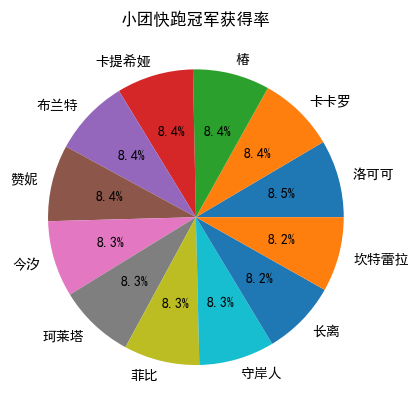

In [49]:
def main() -> None: # 主函数
    time_src = time.time()
    for i in range(Times): # 十万次模拟
        winner = Running_Cubes(cubes = Cubes)
        Win_Rate[winner] += 1
        # 刷新进度条
        time_dst = time.time()
        if time_dst - time_src >= 1: # 刷新进度条
            time_src = time_dst
            status_bar = Status_Bar(status = i)
            os.system("clear")
            sys.stdout.write("\r模拟进度: ")
            sys.stdout.write(status_bar)
    Show_Win_Rate(win_rate = Win_Rate)

if __name__ == "__main__": # 运行主函数
    main()